In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
sns.set()

In [2]:
def build_dataset(words, n_words, atleast=1):
    count = [['PAD', 0], ['GO', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    counter = [i for i in counter if i[1] >= atleast]
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [3]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read().split()

In [4]:
vocabulary_size = len(list(set(shakespeare)))
data, count, dictionary, rev_dictionary = build_dataset(shakespeare, vocabulary_size)

In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 from_dict_size, to_dict_size, learning_rate, batch_size):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.GRUCell(size_layer,reuse=reuse)
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        batch_size = tf.shape(self.X)[0]
        
        encoder_embedding = tf.Variable(tf.random_uniform([from_dict_size, embedded_size], -1, 1))
        decoder_embedding = tf.Variable(tf.random_uniform([to_dict_size, embedded_size], -1, 1))
        
        _, encoder_state = tf.nn.dynamic_rnn(
            cell = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)]), 
            inputs = tf.nn.embedding_lookup(encoder_embedding, self.X),
            sequence_length = self.X_seq_len,
            dtype = tf.float32)
        main = tf.strided_slice(self.Y, [0, 0], [batch_size, -1], [1, 1])
        decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
        dense = tf.layers.Dense(to_dict_size)
        decoder_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        
        training_helper = tf.contrib.seq2seq.TrainingHelper(
                inputs = tf.nn.embedding_lookup(decoder_embedding, decoder_input),
                sequence_length = self.Y_seq_len,
                time_major = False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell = decoder_cells,
                helper = training_helper,
                initial_state = encoder_state,
                output_layer = dense)
        training_decoder_output, _, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = training_decoder,
                impute_finished = True,
                maximum_iterations = tf.reduce_max(self.Y_seq_len))
        self.training_logits = training_decoder_output.rnn_output
        
        predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embedding = decoder_embedding,
                start_tokens = tf.tile(tf.constant([GO], dtype=tf.int32), [batch_size]),
                end_token = EOS)
        predicting_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell = decoder_cells,
                helper = predicting_helper,
                initial_state = encoder_state,
                output_layer = dense)
        predicting_decoder_output, _, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = predicting_decoder,
                impute_finished = True,
                maximum_iterations = tf.reduce_max(self.X_seq_len))
        self.predicting_ids = predicting_decoder_output.sample_id
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        self.cost = tf.contrib.seq2seq.sequence_loss(logits = self.training_logits,
                                                     targets = self.Y,
                                                     weights = masks)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        y_t = tf.argmax(self.training_logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.Y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
learning_rate = 0.001
batch_size = 32
sequence_length = 64
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(data) - sequence_length - 1)

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(dictionary), 
                len(dictionary), learning_rate,batch_size)
sess.run(tf.global_variables_initializer())

In [9]:
def train_random_batch():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length + 1))
        for n in range(batch_size):
            index = np.random.randint(0, len(data) - sequence_length - 1)
            batch_x[n] = data[index:index + sequence_length]
            batch_y[n] = data[index + 1:index + sequence_length + 1] + [EOS]
        accuracy, _, loss = sess.run([model.accuracy, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y})
        ACCURACY.append(accuracy); LOST.append(loss)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [10]:
LOST, ACCURACY = train_random_batch()

epoch: 100%|██████████| 3000/3000 [18:25<00:00,  2.72it/s, accuracy=0.401, cost=3.11] 


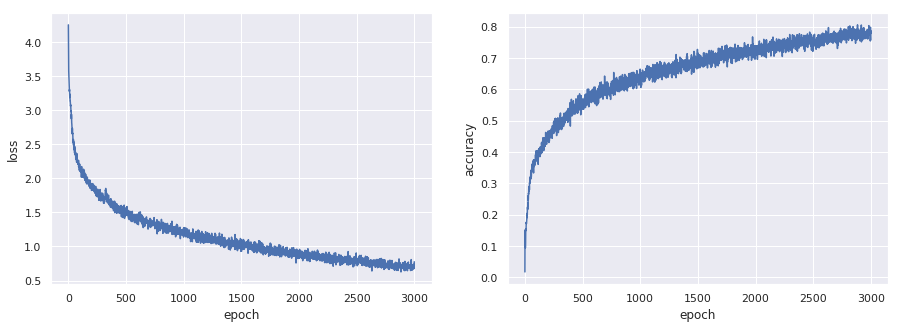

In [11]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

array([[ 4,  6,  7, 12, 24, 17,  5, 10, 29, 14, 14, 51, 44, 41, 45, 35,
        39, 39,  4, 46,  8, 11, 23, 13, 17, 10,  4, 22,  7, 15, 15,  7,
        21,  5, 11, 28, 14, 43,  5,  4,  9,  5,  8, 11,  4,  6,  9,  5,
         4, 18,  8, 12,  4,  7, 22,  4, 27, 11,  7, 31,  5, 20,  4,  8]],
      dtype=int32)

In [23]:
def generate_based_sequence(length_sentence):
    index = np.random.randint(0, len(data) - sequence_length - 1)
    ids = sess.run(model.predicting_ids, feed_dict = {model.X:[data[index:index + sequence_length]]})[0]
    ids = ids.tolist()

    while len(ids) < length_sentence:
        new_ids = sess.run(model.predicting_ids, feed_dict = {model.X:[ids[-sequence_length:]]})[0]
        new_ids = new_ids.tolist()
        ids += new_ids

    return ''.join([rev_dictionary[i] for i in ids])

In [24]:
print(generate_based_sequence(1000))

ar this worfort we have a king:
Better in the cannot swear in cor this worforth we again. I hear in them
Because it on the cause this worfort way fought a king.
Where in the can on the kings.
this worfort way for what in he
With cereman to know in the chanhis worforw worth a woman with
her citizen the mocked in hang.

is worforw worth water woman
With her comminted the king condents worforw worth water
would make him the crown in the king.

BUC worforwow worth
wate worth me hither can to give king.

BUCKINGworforwoworw
worth water worth the city can give king.

BUCKINGHorfowrow
wortworth war worth the city can give king.

BUCKINGHAMrfowrow
worthward worthy the cright and king.

KING HENRY BOLINGfoworw
wrown what to her thrick with can delive.

KING HENRY BOEOSowworw
what wront that whom the prince.
His gave know me.

HENRYwwwowrw
what wront that where him.

DUKE VINCENTIO:
He knight hawwwwharw
what wront that where him.

HENRY BOLINGBROKE:
He king wwwharwhat
wrong wather then which.

H